In [2]:
import gym
import pickle
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO  # DDPG, SAC, TD3
from stable_baselines3.common.monitor import Monitor
from chameleon import Chameleon

In [15]:
target_pos = 0.18
E = 1.0
env = Chameleon(E=E, target_pos=target_pos)
wrapped = Monitor(env, filename="logger_file")
# model = PPO(
#     "MlpPolicy",
#     wrapped,
#     gamma=1,
#     learning_rate=1e-4,
#     verbose=0,
#     tensorboard_log="./ppo_tensorboard/",
# )
# model.learn(total_timesteps=int(1e6), n_eval_episodes=1)

NameError: name 'env' is not defined

In [14]:
model = PPO(
    "MlpPolicy",
    wrapped,
    gamma=1,
    learning_rate=1e-4,
    verbose=0,
)
model.load("1000000_steps_ppo.zip")

NameError: name 'wrapped' is not defined

In [ ]:
# pos_hist = []
# state = env.reset()
# # pos_hist.append(env.pos)
# done = False
# while not done:
#     pos_hist.append(env.pos)
#     action = model.predict(state, deterministic=True)[0]  # need to do deterministic for PPO
#     print(action)
#     state, rew, done, _ = env.step(action)

In [ ]:
# pos_hist.append(env.winning_pos)

In [ ]:
# history = []
# for i in range(len(pos_hist)):
#     x_p = pos_hist[i]
#     y = np.zeros(env.n_elems)
#     ar = np.vstack((x_p, y)).T
#     history.append(ar)

# with open("winning_history.txt", "wb") as fp:
#     pickle.dump(history, fp)

In [ ]:
# model.save("one_million_ppo")

## max distance E = 1 agent can reach with the given torques is 0.21. How did i find that? By applying the max torque for each time step until the episode was over.

In [5]:
# rews = np.loadtxt("logger_file.monitor.csv", delimiter=',', skiprows=2, usecols=(0,))

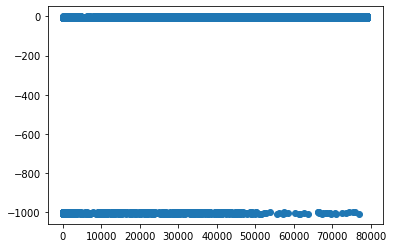

In [13]:
# plt.plot(rews, 'o')